In a previous notebook, we introduced the new channel models for NTN channels, how to generate them, and what their properties are. In this notebook, we will use the channel models to simulate different transmissions and generate Bit Error Rate (BER) curves. This notebook showcases how to create channel transmission data, as well as full end to end systems. 
As this topic is already covered in multiple existing Sionna tutorials and the user interface of the new NTN channels is kept close to the existing channel models based on the standard 3GPP TR38.901 for terrestrial simulations, we will not go into much detail regarding the setup of the simulations in this notebook.

First, we import all necessary libraries.

In [ ]:
#General imports
import sionna
import tensorflow as tf
import numpy as np

#Setup to use GPU
import os
gpu_num = 0 # Use "" to use the CPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sionna.config.xla_compat=True

#Specific components used in this simulation
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers
from sionna.mimo import StreamManagement
from sionna.phy.channel.tr38811 import AntennaArray, DenseUrban, Urban, SubUrban
from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.channel import OFDMChannel
from sionna.utils import compute_ber as CountBitErrors
#Used to track time and save results
import time
import pickle
import matplotlib.pyplot as plt

# It is important to use the new topology generation function.
from sionna.phy.channel.tr38811.utils import gen_single_sector_topology as gen_ntn_topology

XLA can lead to reduced numerical precision. Use with care.


Next we define our setup. We have chosen a MIMO simulation in uplink between two users with a singular antenna and a satellite in LEO orbit with an antenna array. Both the setup of the OFDM frame as well as any other elements of the end to end model can be adjusted freely. However, using more than two users and standard channel processing elements is very likely to degrade the performance very significantly. 

The end to end system follows this order: 
A bit source generates bits for both users. The bits are encoded using a half rate code and the existing LDPC encoder implementation of Sionna. The encoded bits are mapped to 4QAM symbols, which are then mapped to a predefined OFDM resource grid. The symbols in these OFDM frames are transmitted via the defined OFDM NTN channel. If perfect Channel State Information (CSI) is given, only the information carrying symbols from the frame are extracted. If not, the channel is estimated using a Least Squares (LS) channel estimator. The received symbols are then equalized using a Linear Minimum Mean Squared Error (LMMSE) equalizer and the channel information (perfect or estimated). After equalization, the symbols are demapped and decoded using the corresponding LDPC decoder. In the end, the BER and Block Error Rate (BLER) of the received bits is calculated and returned.

One of the advantages of this framework, is that all results from intermediate steps are always fully accessible. So if for example the channel estimates are investigated, the actual the received symbols, the channel estimates, and the exact CSI are all available.

Let's set the system up by first defining all elements.

In [21]:
# Parameters of Simulation

# Geometry
scenario = "dur"
direction = "downlink"
carrier_frequency = 3.5e9
elevation_angle = 50.0
num_ut = 1
num_ut_ant = 1
num_bs_ant = 1
sat_height = 600000.0
# Signal
num_bits_per_symbol = 2 # for 4QAM
coderate = 526.0/1024.0
# OFDM
num_ofdm_symbols = 12
cyclic_prefix_length = 10
pilot_ofdm_symbol_indices = [2]
subcarrier_spacing = 15e3
fft_size = 52*12 # 12 Resource Blocks (RBs) with 12 subcarriers each
# Simulation
ebno_db = 10.0 # Noise, Energy per Bit per Noise ratio in dB
batch_size = 128
perfect_csi = True
doppler_enabled = True


# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Tx and Rx roles depend on the link direction
if direction == "uplink":
    num_tx = num_ut
    num_streams_per_tx = num_ut_ant
    rx_tx_association = np.zeros([1, num_ut])
    rx_tx_association[0, :] = 1
    rx_tx_association = rx_tx_association
elif direction == "downlink":
    num_tx = 1
    num_streams_per_tx = num_bs_ant
    rx_tx_association = np.zeros([num_ut, 1])
    rx_tx_association[:, 0] = 1
    rx_tx_association = rx_tx_association
else:
    print("Direction invalid, choose either uplink or downlink.")

# Setup an OFDM Resource Grid
rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                        fft_size=fft_size,
                        subcarrier_spacing=subcarrier_spacing,
                        num_tx=num_tx,
                        num_streams_per_tx=num_streams_per_tx,
                        cyclic_prefix_length=cyclic_prefix_length,
                        pilot_pattern="kronecker",
                        pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices)

# Setup StreamManagement
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

# Antennas
ut_array = AntennaArray(
                        num_rows=1,
                        num_cols=num_ut_ant,
                        polarization="single",
                        polarization_type="V",
                        antenna_pattern="omni",
                        carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=num_bs_ant,
                        polarization="single",
                        polarization_type="V",
                        antenna_pattern="aperture",
                        carrier_frequency=carrier_frequency)

# Channel
channel_model = DenseUrban(carrier_frequency=carrier_frequency,
                                    ut_array=ut_array,
                                    bs_array=bs_array,
                                    direction=direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)

Now we define the elements of the end to end system.

In [22]:
# Transmitter part
binary_source = BinarySource()

n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate)                              # Number of information bits
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder)
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(rg)
# Creates a new channel realization
topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario=scenario)
channel_model.set_topology(*topology)

# Channel. This channel takes the underlying functionality of the NTN channel and returns
# an easy to use channel that directly takes OFDM frames, without the user needing to manually
# define the channel behavior on the OFDM frame.
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True,
                                        normalize_channel=True, return_channel=True)

# Receiver Part
remove_nulled_subcarriers = RemoveNulledSubcarriers(rg)
ls_est = LSChannelEstimator(rg, interpolation_type="nn")
lmmse_equ = LMMSEEqualizer(rg, sm)
demapper = Demapper("app", "qam", num_bits_per_symbol, hard_out=True)

With these elements at hand, we can now execute the steps of the transmission.

In [23]:
# Transforms the desired noise in energy per information bit to the correct value for
# the coderate, bits per symbol, and the resource grid
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg) * num_bits_per_symbol #Convert Eb/N0 to Es/N0
# Generates bits for each users upstream in sizes of k (number informaion bits per OFDM frame)
b = binary_source([batch_size, num_tx, num_streams_per_tx, k])
c = encoder(b)
# Maps encoded bits to 4QAM symbols
x = mapper(c)
# Maps symbols to defined OFDM frame format (resource grid)
x_rg = rg_mapper(x)

# Transmit bits over ofdm_channel
y, h = ofdm_channel([x_rg, no])

# Estimate channel
if perfect_csi:
    h_hat = remove_nulled_subcarriers(h)
    err_var = 0.0
else:
    h_hat, err_var = ls_est([y, no])
# Equalize channel based on estimation
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
# Demap and decode the received symbols
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)

print("Bit Error Rate is: ", CountBitErrors(b, b_hat))

Bit Error Rate is:  tf.Tensor(0.07762086051623883, shape=(), dtype=float64)


In [ ]:
class Model(tf.keras.Model):
    """
    Simulate OFDM MIMO transmissions over a 3GPP 38.811 model.
    """
    def __init__(self, scenario, perfect_csi, doppler_enabled, elevation_angle = 50.0, enable_pathloss = True):
        super().__init__()
        "Setup for Case1 TABLE 25 as defined in 6G-NTN report D4.1"
        self._scenario = scenario
        self._perfect_csi = perfect_csi

        # Internally set parameters
        self._carrier_frequency = 3.5e9
        self._fft_size = 52*12
        self._subcarrier_spacing = 15e3
        self._num_ofdm_symbols = 12
        self._cyclic_prefix_length = 10
        self._pilot_ofdm_symbol_indices = [2]
        # The Equalizer used later assumes the users to receive individual streams. Thus the number of 
        # streams in the downlink (which is equal to the number of basestation antennas) has to be at 
        # least the same as the number of users.
        self._num_bs_ant = 1
        self._num_ut = 1
        self._num_ut_ant = 1
        self._num_bits_per_symbol = 2
        self._coderate = 526.0/1024.0
        self._direction = "downlink"
        self._sat_height = 600000.0

        # Create an RX-TX association matrix
        # rx_tx_association[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. 
        if self._direction == "uplink":
            self._num_tx = self._num_ut
            self._num_streams_per_tx = self._num_ut_ant
            rx_tx_association = np.zeros([1, self._num_ut])
            rx_tx_association[0, :] = 1
            self._rx_tx_association = rx_tx_association
        elif self._direction == "downlink":
            self._num_tx = 1
            self._num_streams_per_tx = self._num_bs_ant
            rx_tx_association = np.zeros([self._num_ut, 1])
            rx_tx_association[:, 0] = 1
            self._rx_tx_association = rx_tx_association
        else:
            print("Direction invalid, choose either uplink or downlink.")


        # Setup an OFDM Resource Grid
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing=self._subcarrier_spacing,
                                num_tx=self._num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Setup StreamManagement
        self._sm = StreamManagement(self._rx_tx_association, self._num_streams_per_tx)

        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                num_rows=1,
                                num_cols=self._num_ut_ant,
                                polarization="single",
                                polarization_type="V",
                                antenna_pattern="omni",
                                carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                    num_cols=self._num_bs_ant,
                                    polarization="single",
                                    polarization_type="V",
                                    antenna_pattern="aperture",
                                    carrier_frequency=self._carrier_frequency)

        # Configure the channel model
        if scenario == "dur":
            self._channel_model = DenseUrban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled,
                                    enable_pathloss=enable_pathloss)
        elif scenario == "sur":
            self._channel_model = SubUrban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled,
                                    enable_pathloss=enable_pathloss)
        elif scenario == "urb":
            self._channel_model = Urban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled,
                                    enable_pathloss=enable_pathloss)

        # Instantiate other building blocks
        self._binary_source = BinarySource()

        self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol) # Number of coded bits
        self._k = int(self._n*self._coderate)                              # Number of information bits
        self._encoder = LDPC5GEncoder(self._k, self._n)
        # In this example we will consider the uncoded BER, so the decoder is not used. However,
        # by adapting the final function, you can use it and investigate coded BER or BLER
        self._decoder = LDPC5GDecoder(self._encoder)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        self._ofdm_channel = OFDMChannel(self._channel_model, self._rg, add_awgn=True,
                                        normalize_channel=True, return_channel=True)

        self._remove_nulled_subcarriers = RemoveNulledSubcarriers(self._rg)
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        # As we are interested in the uncoded BER, the output is hard. If you are interested in the coded BER
        # or BLER, change this to False
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol, hard_out=True)

    def new_topology(self, batch_size):
        topology = gen_ntn_topology(batch_size=batch_size, num_ut=self._num_ut, scenario=self._scenario, bs_height=self._sat_height)
        self._channel_model.set_topology(*topology)
        

    # The tf function does have certain interactions with the processing blocks. The LMMSE Equalizer makes a few assumptions about the 
    # system, which can result in error messages, if the user configure them in certain ways. Short guidelines:
    # Commenting out the tf function: code always works
    # Leaving the @tf.function in, but setting @tf.function(jit_compile=False): Works for MISO and MIMO
    # Leaving tf in and setting @tf.function(jit_compile=True): In Downlink it requires multiple UTs. The UTs can have a single antenna, but you need at least
    #   2 and you need at least 2 basestation antennas. Not having seperate spatial streams for seperate UTs creates shape mismatches.
    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)
        # The function ebnodb2no is used to conveniently calculate Eb/N0, however we are interested in
        # Es/N0 and thus convert by multiplying with the number of bits per symbol.
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg) * self._num_bits_per_symbol
        b = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        y, h = self._ofdm_channel([x_rg, no])

        if self._perfect_csi:
            h_hat = self._remove_nulled_subcarriers(h)
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est([y, no])

        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        c_hat = self._demapper([x_hat, no_eff])
        # If you are interested in the coded BER or BLER, comment the following lines out
        # b_hat = self._decoder(llr)
        # return b_hat, b
        return c, c_hat

We will simulate over a range of -5 to 15 dB and varying perfect and imperfect csi and with and without doppler.

In [25]:
SIMS = {
    "ebno_db" : list(np.arange(0.0, 15.5, 1.0)),
    "scenario" : ["dur", "sur", "urb"],
    "perfect_csi" : [True],
    "doppler_enabled" : [True],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

Now we run the simulations. On a GPU this will run relatively fast, but if you only want to just use the results, we can uncomment the cell after the next one containing the results.

In [26]:
start = time.time()

for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
        for doppler_enabled in SIMS["doppler_enabled"]:

            model = Model(scenario=scenario,
                        perfect_csi=perfect_csi,
                        doppler_enabled=doppler_enabled,
                        enable_pathloss=True)
            
            ber, bler = sim_ber(model,
                                SIMS["ebno_db"],
                                batch_size=128,
                                max_mc_iter=10e5,
                                num_target_block_errors=10000)

            SIMS["ber"].append(list(ber.numpy()))
            SIMS["bler"].append(list(bler.numpy()))

            with open('Example_NTN_sim.pkl', 'wb') as f:
                pickle.dump(SIMS, f)

SIMS["duration"] = time.time() -  start

print("Simulations took ", SIMS["duration"])

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.5696e-01 | 1.0000e+00 |    35670581 |   138817536 |        10112 |       10112 |        49.5 |reached target block errors
      1.0 | 2.3244e-01 | 1.0000e+00 |    32267112 |   138817536 |        10112 |       10112 |        31.3 |reached target block errors
      2.0 | 2.0701e-01 | 1.0000e+00 |    28736065 |   138817536 |        10112 |       10112 |        31.7 |reached target block errors
      3.0 | 1.8086e-01 | 1.0000e+00 |    25106806 |   138817536 |        10112 |       10112 |        31.5 |reached target block errors
      4.0 | 1.5498e-01 | 1.0000e+00 |    21514488 |   138817536 |        10112 |       10112 |        31.0 |reached target block errors
      5.0 | 1.2962e-01 | 1.0000e+00 |    17993132 |   138817536 |

In [27]:
#SIMS = {'ebno_db': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0], 'scenario': ['dur', 'sur', 'urb'], 'perfect_csi': [True], 'doppler_enabled': [True], 'ber': [[0.2564537307447958, 0.23286204273212283, 0.20731667503448556, 0.1812997890986914, 0.1544545784186805, 0.12855348477010858, 0.10496572997809153, 0.0825947955163244, 0.06315192772186938, 0.046326798366454223, 0.03411548091445738, 0.025051885375634388, 0.01708043571670945, 0.012685825226000265, 0.0094084006792917, 0.006915591461489899], [0.2500386406512791, 0.2250492689914911, 0.19867006571849827, 0.17142323430953277, 0.14382818320590274, 0.11687787773440958, 0.09120310995867266, 0.06824226443552492, 0.048952043061764185, 0.031798885985125105, 0.019814751646362604, 0.011880084083901331, 0.0065688746989429345, 0.0037343192721703404, 0.0021853651112205305, 0.00164101000335715], [0.2518424689514731, 0.22659277715460963, 0.20073514343317547, 0.17398643352955062, 0.1464338266312406, 0.12024393661619236, 0.09551890475854578, 0.07158525706723393, 0.05162092777673276, 0.035459677082872294, 0.023306666385434185, 0.014913339190806556, 0.008702812589902187, 0.005595517845814523, 0.0036442730117324657, 0.002615142824378592]], 'bler': [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985166139240507, 0.8762152777777777], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9912974683544303, 0.6847826086956522], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949564873417721, 0.7783106435643564]], 'duration': None}

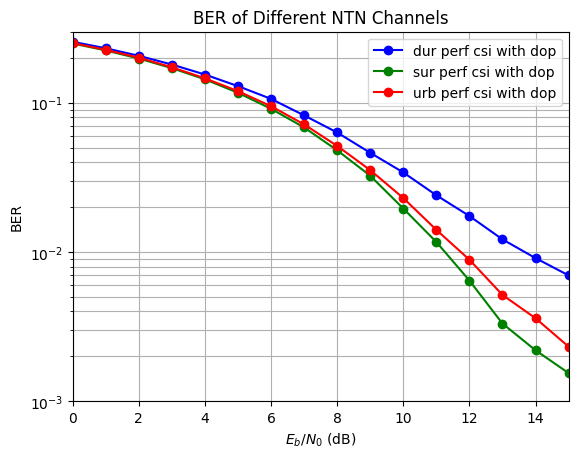

In [28]:
plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")

i=0
legend = []
for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
        for doppler_enabled in SIMS["doppler_enabled"]:
            
            # The legend is setup to showcase multiple different scenarios, in this example we only show 
            # perfect CSI and enabled Doppler
            legend_str = ""

            if scenario=="urb":
                color = "red"
                legend_str+="urb "
            elif scenario=="dur":
                color = "b"
                legend_str+="dur "
            else:
                color = "g"
                legend_str+="sur "

            if perfect_csi:
                marker='o'
                legend_str+="perf csi "
            else:
                marker='x'
                legend_str+="imp csi "
            
            if doppler_enabled:
                linestyle="-"
                legend_str+="with dop"
            else:
                linestyle="-."
                legend_str+="no dop"


            plt.plot(SIMS["ebno_db"], SIMS["ber"][i], marker=marker, linestyle=linestyle,color=color)
            legend.append(legend_str)

            i += 1
plt.legend(legend)
plt.ylim([1e-3, 0.3])
plt.xlim(0,15)
plt.title("BER of Different NTN Channels");
plt.yscale('log')

As we can see, the performances differ. The suburban scenario performs the best, while the dense urban scenario performs the worst. This matches the line of sight probabilities for the scenarios at this respective angle.